In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/test/PNEUMONIA/person1676_virus_2892.jpeg
/kaggle/input/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/test/PNEUMONIA/person1650_virus_2852.jpeg
/kaggle/input/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/test/PNEUMONIA/person22_virus_55.jpeg
/kaggle/input/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/test/PNEUMONIA/person122_bacteria_582.jpeg
/kaggle/input/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/test/PNEUMONIA/person85_bacteria_417.jpeg
/kaggle/input/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/test/PNEUMONIA/person79_virus_148.jpeg
/kaggle/input/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/test/PNEUMONIA/person29_virus_64.jpeg
/kaggle/input/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/test/PNEUMONIA/person123_bacteria_587.jpeg
/kaggle/input/pediatric-pneumonia-chest-xray/Pediatric Ch

## Importing Liabraries

In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE=256
BATCH_SIZE=64
CHANNELS=3
EPOCHS=10

In [4]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    '../input/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/train',
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5232 files belonging to 2 classes.


2022-06-06 18:30:15.472739: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-06 18:30:15.591046: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-06 18:30:15.592030: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-06 18:30:15.594327: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [5]:
class_names=dataset.class_names
class_names

['NORMAL', 'PNEUMONIA']

In [6]:
len(dataset),32*164

(82, 5248)

In [7]:
for image_batch,label_batch in dataset.take(1): # Taking 1 batch
    print(image_batch.shape)
    print(label_batch.numpy())

2022-06-06 18:30:18.673429: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(64, 256, 256, 3)
[1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 0 0 1 1 1 1
 1 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 1 0 1 0 1 1 0 1 1]


## Visualization

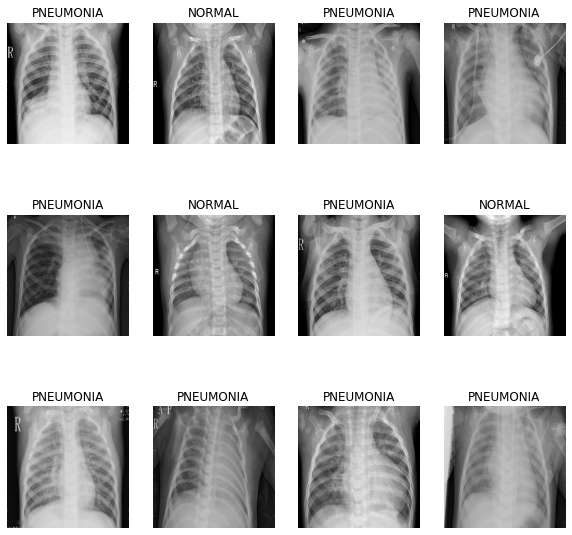

In [8]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

## Data Preparation

In [9]:
# train_size=0.8
# print(len(dataset)*train_size)
# print('We take 65 out of 82 in training')
# train_ds=dataset.take(65)
# print('Train_DS',len(train_ds))
# print('We take remaining 17 into test')
# test_ds=dataset.skip(65)
# print('Test_DS',len(test_ds))
# val_size=0.1
# print(len(dataset)*val_size)
# print('we take 8 in validation and test that is 10%')
# val_ds=test_ds.take(16)
# print('Val',len(val_ds))
# test_ds=test_ds.skip(16)
# print('Test:',len(test_ds))

In [10]:
def dataset_split(data, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

    data_size = len(data)
    if shuffle:
        data=data.shuffle(shuffle_size,seed=12)

    train_size = int(data_size*train_split)
    val_size = int(data_size*val_split)

    train_ds = data.take(train_size)
    val_ds = data.skip(train_size).take(val_size)
    test_ds = data.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds=dataset_split(dataset)

In [12]:
print('Train: ',len(train_ds))
print('Val: ',len(val_ds))
print('Test: ',len(test_ds))


Train:  65
Val:  8
Test:  9


In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(
    buffer_size=tf.data.AUTOTUNE)  # This improves the performance in pipeline
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [15]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),

])

## Model Creation

In [16]:
input_shape = (BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE,CHANNELS)
n_classes=3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),

])
model.build(input_shape=input_shape)


In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (64, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (64, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (64, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (64, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (64, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (64, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (64, 60, 60, 64)         

In [18]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:

history = model.fit(train_ds,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=1,
                    validation_data=val_ds)

Epoch 1/10


2022-06-06 18:30:41.670787: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 13 of 10000
2022-06-06 18:30:51.503581: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 30 of 10000
2022-06-06 18:31:01.733988: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 49 of 10000
2022-06-06 18:31:11.582451: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 67 of 10000
2022-06-06 18:31:15.457778: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2022-06-06 18:31:15.457875: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1 of 1000
2022-06-06 18:31:15.457906: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 2 of 1000
2

65/65 [==============================] - ETA: 0s - loss: 0.6125 - accuracy: 0.7254

2022-06-06 18:31:37.874845: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 19 of 10000
2022-06-06 18:31:47.857905: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 46 of 10000
2022-06-06 18:31:57.811531: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 65 of 10000
2022-06-06 18:32:03.032174: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2022-06-06 18:32:03.189141: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1 of 1000
2022-06-06 18:32:03.189206: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 2 of 1000
2022-06-06 18:32:03.189243: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 3 of 1000
202

65/65 [==============================] - 93s 632ms/step - loss: 0.6125 - accuracy: 0.7254 - val_loss: 0.5496 - val_accuracy: 0.7324
Epoch 2/10
65/65 [==============================] - 4s 66ms/step - loss: 0.4839 - accuracy: 0.7809 - val_loss: 0.4273 - val_accuracy: 0.7695
Epoch 3/10
65/65 [==============================] - 4s 66ms/step - loss: 0.2876 - accuracy: 0.8711 - val_loss: 0.2288 - val_accuracy: 0.9062
Epoch 4/10
65/65 [==============================] - 4s 67ms/step - loss: 0.2524 - accuracy: 0.8970 - val_loss: 0.2205 - val_accuracy: 0.9082
Epoch 5/10
65/65 [==============================] - 4s 66ms/step - loss: 0.2340 - accuracy: 0.9042 - val_loss: 0.2211 - val_accuracy: 0.9004
Epoch 6/10
65/65 [==============================] - 4s 65ms/step - loss: 0.2091 - accuracy: 0.9148 - val_loss: 0.2335 - val_accuracy: 0.9199
Epoch 7/10
65/65 [==============================] - 4s 66ms/step - loss: 0.2055 - accuracy: 0.9177 - val_loss: 0.2541 - val_accuracy: 0.8926
Epoch 8/10
65/65 [====

In [20]:
scores=model.evaluate(test_ds)

2022-06-06 18:33:44.835831: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 16 of 10000
2022-06-06 18:33:54.862878: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 43 of 10000
2022-06-06 18:34:04.889612: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 69 of 10000


1/9 [==>...........................] - ETA: 4:21 - loss: 0.1885 - accuracy: 0.9219

2022-06-06 18:34:06.972744: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2022-06-06 18:34:07.138547: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1 of 1000
2022-06-06 18:34:07.138615: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 2 of 1000
2022-06-06 18:34:07.138646: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 3 of 1000
2022-06-06 18:34:07.139110: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


9/9 [==============================] - 33s 23ms/step - loss: 0.1629 - accuracy: 0.9358


In [21]:
scores

[0.16293182969093323, 0.9357638955116272]

In [22]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 65}

In [23]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

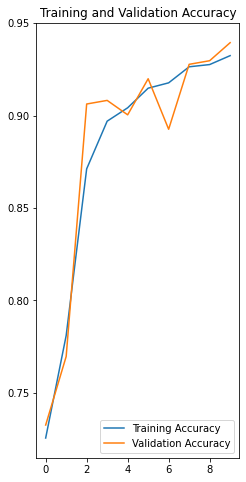

Text(0.5, 1.0, 'Training and Validation Loss')

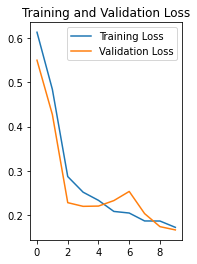

In [24]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')


## Prediction

image to predict
Actual Label:  PNEUMONIA
Predicted Label:  PNEUMONIA


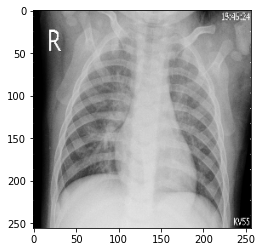

In [25]:
#Checking randomly the test images and if our model predicted the correct class
#Change the i to any index.

i = 4
for images_batch, labels_batch in test_ds.take(1):
  first_image = images_batch[i].numpy().astype('uint8')
  first_label = labels_batch[i].numpy()

  print("image to predict")
  plt.imshow(first_image)
  print("Actual Label: ", class_names[first_label])

  batch_prediction = model.predict(images_batch)
  print("Predicted Label: ", class_names[np.argmax(batch_prediction[i])])

In [26]:
#Define a function to predict the class of one single image given as input

def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0) #Creates a batch

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100* (np.max(predictions[0])), 2)

  return predicted_class, confidence

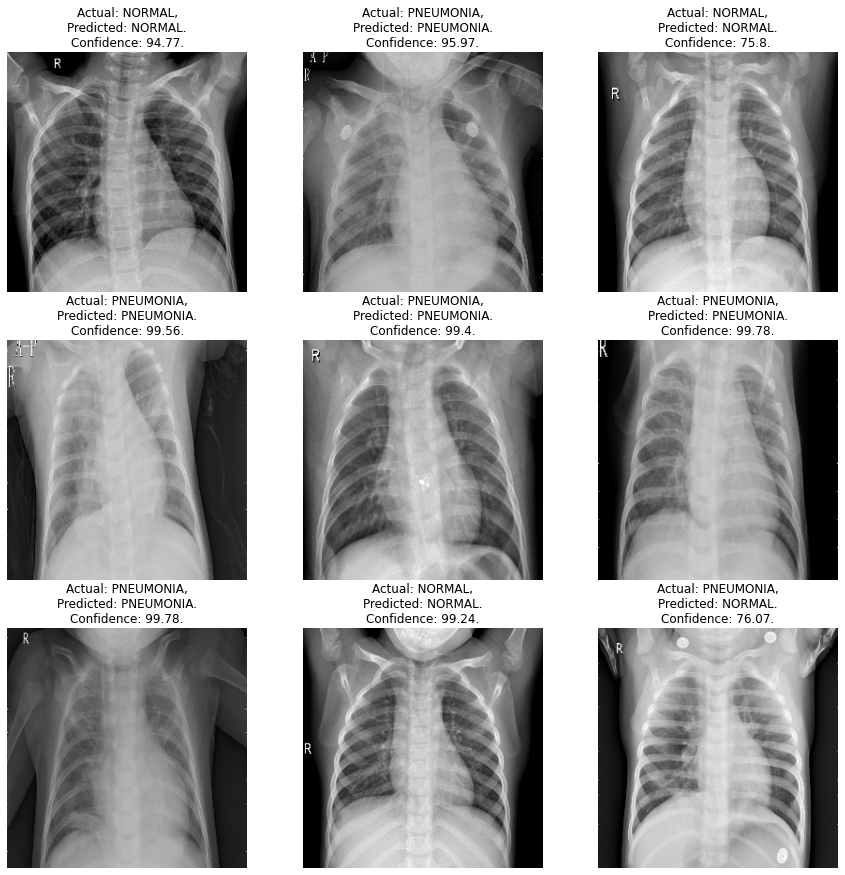

In [27]:
#See the predictions for some images from the test dataset

plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.axis('off')
    plt.imshow(images[i].numpy().astype('uint8'))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class}.\nConfidence: {confidence}.")

In [28]:
model.save("pneumonia_prediction_model_3.h5")